In [1]:
import os
import cv2
import tensorflow as tf
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
# prevent exponentional memory growth
physical_devices = tf.config.list_logical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
    pass

In [3]:
# two build functions one for image and one for dataset
import gdown

url = "https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL"
output = 'data.zip'
gdown.download(url,output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=05c39a12-7961-48d2-93f7-a543f4cf2d54
To: c:\Users\Aaron\OneDrive\Desktop\github\lipReadMLModel\data.zip
100%|██████████| 423M/423M [02:56<00:00, 2.40MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [4]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean),tf.float32)/std


In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!1234567890"]

In [7]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}"
    f"(size={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0'](size=40)


In [8]:
def load_alignments(path:str) -> List[str]:
    with open(path,'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [9]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames,alignments

In [10]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [11]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8')

'.\\data\\s1\\bbal6n.mpg'

In [75]:
frames,alignments = load_data(tf.convert_to_tensor(test_path))

tf.Tensor(
[[[1.4603739 ]
  [1.4603739 ]
  [1.4209043 ]
  ...
  [0.15787826]
  [0.19734782]
  [0.07893913]]

 [[1.4603739 ]
  [1.4603739 ]
  [1.4209043 ]
  ...
  [0.15787826]
  [0.07893913]
  [0.03946957]]

 [[1.4209043 ]
  [1.4209043 ]
  [1.3814348 ]
  ...
  [0.07893913]
  [0.07893913]
  [0.07893913]]

 ...

 [[0.94726956]
  [0.94726956]
  [0.94726956]
  ...
  [9.94633   ]
  [9.867392  ]
  [9.867392  ]]

 [[0.94726956]
  [0.94726956]
  [0.94726956]
  ...
  [9.90686   ]
  [9.867392  ]
  [9.867392  ]]

 [[0.94726956]
  [0.94726956]
  [0.94726956]
  ...
  [9.90686   ]
  [9.867392  ]
  [9.867392  ]]], shape=(46, 140, 1), dtype=float32)


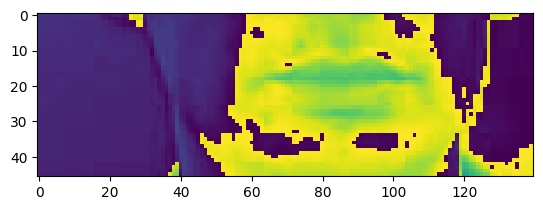

In [76]:
plt.imshow(frames[0])
print(frames[0])

In [78]:
bytes.decode(tf.strings.reduce_join([x for x in num_to_char(alignments)]).numpy())

'binblueatlsixnow'

In [84]:
# helps use to get data from file name
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path],(tf.float32,tf.int64))
    return result

In [85]:
#make a datapipeline

data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500)
data = data.map(mappable_function)
data = data.padded_batch(2,padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [86]:
frames, alignments = data.as_numpy_iterator().next()

In [87]:
alignments

array([[19,  5, 20,  0, 18,  5,  4,  0,  9, 14,  0,  1,  0,  5,  9,  7,
         8, 20,  0, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20,  0, 23,  8,  9, 20,  5,  0, 23,  9, 20,  8,  0,  9,
         0,  5,  9,  7,  8, 20,  0, 14, 15, 23,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [88]:
len(frames)

2

In [89]:
test = data.as_numpy_iterator()

In [90]:
val = test.next(); 
val[0][1]

array([[[[0.9770344 ],
         [1.3287668 ],
         [1.446011  ],
         ...,
         [0.312651  ],
         [0.27356964],
         [0.27356964]],

        [[0.7034648 ],
         [1.2115227 ],
         [1.3678482 ],
         ...,
         [0.312651  ],
         [0.27356964],
         [0.27356964]],

        [[0.82070893],
         [1.2896854 ],
         [1.446011  ],
         ...,
         [0.3517324 ],
         [0.312651  ],
         [0.312651  ]],

        ...,

        [[1.0942786 ],
         [1.0942786 ],
         [1.1333599 ],
         ...,
         [0.07816275],
         [0.07816275],
         [0.07816275]],

        [[1.1333599 ],
         [1.1333599 ],
         [1.0942786 ],
         ...,
         [0.07816275],
         [0.07816275],
         [0.07816275]],

        [[1.1333599 ],
         [1.1333599 ],
         [1.0942786 ],
         ...,
         [0.07816275],
         [0.07816275],
         [0.03908138]]],


       [[[0.9770344 ],
         [1.3287668 ],
         [1.40

In [100]:
imageio.v3.imwrite('./animation.gif',val[0][0])

TypeError: Cannot handle this data type: (1, 1, 1), <f4

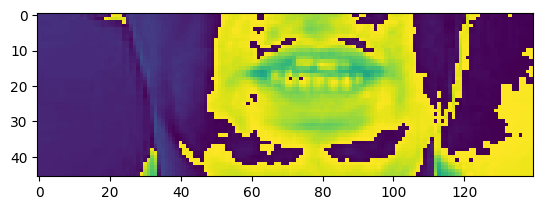

In [93]:
plt.imshow(val[0][0][30])

In [106]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'placeredwithjeightnow'>